In [196]:
import toml
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import sqlalchemy as sa
import datetime
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

sns.set_theme()

In [3]:
config = toml.load("./db.toml")['psql']
connection_string = f"postgresql://{config['user']}:{config['password']}@{config['host']}:{config['port']}/{config['database']}"

In [4]:
conn = sa.create_engine(connection_string)

In [5]:
def cdf(series: pd.Series) -> pd.DataFrame:
    """ calculates the cumulative distribution function of the given series"""
    return pd.DataFrame.from_dict({
        series.name: np.append(series.sort_values(), series.max()),
        "cdf": np.linspace(0, 1, len(series) + 1)
    })

In [6]:
sns.set_theme()
dpi = 150

In [7]:
df_runs = pd.read_sql_query("SELECT * FROM runs", con=conn)

In [86]:
query = """
SELECT *
FROM measurements
WHERE error IS NULL
  AND type = 'KUBO'
  AND created_at >= '2023-02-27 00:00'
  AND created_at < '2023-03-06 00:00'
  AND website != 'ipfs.io'
"""
df_measurements = pd.read_sql_query(query, con=conn)

In [87]:
query = """
SELECT *
FROM measurements
WHERE error IS NULL
  AND type = 'KUBO'
  AND created_at >= '2023-02-20 00:00'
  AND created_at < '2023-02-27 00:00'
  AND website != 'ipfs.io'
"""
df_measurements_prev = pd.read_sql_query(query, con=conn)

In [88]:
df = pd.concat([df_measurements, pd.json_normalize(df_measurements['metrics'])], axis=1).drop("metrics", axis=1).merge(df_runs, left_on="run_id", right_on="id")

In [89]:
data = df.copy()
data.head()

,id_x,run_id,region,website,url,version,type,try,node,instance_type,...,regions,urls,settle_short,settle_long,nodes_per_version,versions,times,updated_at,created_at_y,finished_at
0,85697,41,us-west-1,protocol.ai,http://127.0.0.1:8081/ipns/protocol.ai,v0.18.0,KUBO,0,0,t3.medium,...,"[eu-central-1, sa-east-1, ap-southeast-2, us-w...","[protocol.ai, research.protocol.ai, strn.netwo...",10.0,600.0,1,"[v0.18.0, v0.17.0]",3,2023-02-27 01:00:14.198662+00:00,2023-02-27 00:20:56.317943+00:00,2023-02-27 01:00:14.198661+00:00
1,85698,41,us-west-1,protocol.ai,http://127.0.0.1:8081/ipns/protocol.ai,v0.18.0,KUBO,1,0,t3.medium,...,"[eu-central-1, sa-east-1, ap-southeast-2, us-w...","[protocol.ai, research.protocol.ai, strn.netwo...",10.0,600.0,1,"[v0.18.0, v0.17.0]",3,2023-02-27 01:00:14.198662+00:00,2023-02-27 00:20:56.317943+00:00,2023-02-27 01:00:14.198661+00:00
2,85699,41,eu-central-1,protocol.ai,http://127.0.0.1:8081/ipns/protocol.ai,v0.18.0,KUBO,0,0,t3.medium,...,"[eu-central-1, sa-east-1, ap-southeast-2, us-w...","[protocol.ai, research.protocol.ai, strn.netwo...",10.0,600.0,1,"[v0.18.0, v0.17.0]",3,2023-02-27 01:00:14.198662+00:00,2023-02-27 00:20:56.317943+00:00,2023-02-27 01:00:14.198661+00:00
3,85700,41,eu-central-1,protocol.ai,http://127.0.0.1:8081/ipns/protocol.ai,v0.17.0,KUBO,0,1,t3.medium,...,"[eu-central-1, sa-east-1, ap-southeast-2, us-w...","[protocol.ai, research.protocol.ai, strn.netwo...",10.0,600.0,1,"[v0.18.0, v0.17.0]",3,2023-02-27 01:00:14.198662+00:00,2023-02-27 00:20:56.317943+00:00,2023-02-27 01:00:14.198661+00:00
4,85701,41,us-west-1,protocol.ai,http://127.0.0.1:8081/ipns/protocol.ai,v0.18.0,KUBO,2,0,t3.medium,...,"[eu-central-1, sa-east-1, ap-southeast-2, us-w...","[protocol.ai, research.protocol.ai, strn.netwo...",10.0,600.0,1,"[v0.18.0, v0.17.0]",3,2023-02-27 01:00:14.198662+00:00,2023-02-27 00:20:56.317943+00:00,2023-02-27 01:00:14.198661+00:00


In [90]:
df_prev = pd.concat([df_measurements_prev, pd.json_normalize(df_measurements_prev['metrics'])], axis=1).drop("metrics", axis=1).merge(df_runs, left_on="run_id", right_on="id")

In [91]:
data_prev = df_prev.copy()

In [92]:
def get_percentiles(data: pd.DataFrame, percentile: float = 0.5, metric: str = "performanceTimingPageLoad"):
    agg = data[["website", "region", metric]].groupby(["website", "region"]).quantile(percentile,
                                                                                      numeric_only=True).reset_index()

    row_labels = list(sorted(agg["region"].unique()))
    col_labels = list(sorted(agg["website"].unique()))
    dat = []
    counts = []
    for region in row_labels:
        region_values = []
        region_counts = []
        for website in col_labels:
            region_counts += [df[(df["region"] == region) & (df["website"] == website)].count().iloc[0]]
            series = agg[(agg["region"] == region) & (agg["website"] == website)][metric]
            if len(series) > 0:
                region_values += [series.iloc[0] / 1000]
            else:
                region_values += [np.NAN]
        dat += [region_values]
        counts += [region_counts]
    dat = np.array(dat)
    counts = np.array(counts)
    return dat, counts, row_labels, col_labels

In [93]:
def plot_metric(title: str, metric: str):
    fig, axes = plt.subplots(3, 1, figsize=[18, 15])

    pos = None
    for idx, percentile in enumerate([0.5, 0.9, 0.99]):
        cbar_kw = {}

        dat, counts, row_labels, col_labels = get_percentiles(data, percentile, metric)
        dat_prev, counts_prev, row_labels_prev, col_labels_prev = get_percentiles(data_prev, percentile, metric)

        ax = fig.axes[idx]

        im = ax.imshow(dat, cmap=sns.color_palette("rocket_r", as_cmap=True))

        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(f"p{int(percentile * 100)} Latency in Seconds", rotation=-90, va="bottom")

        # Show all ticks and label them with the respective list entries.
        if idx == 0:
            ax.set_title(title)
            ax.set_xticks(np.arange(dat.shape[1]), labels=col_labels)
        else:
            ax.set_xticks([], labels=[])

        ax.set_yticks(np.arange(dat.shape[0]), labels=row_labels)

        # Let the horizontal axes labeling appear on top.
        ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

        # Turn spines off and create white grid.
        ax.spines[:].set_visible(False)

        ax.set_xticks(np.arange(dat.shape[1] + 1) - .5, minor=True)
        ax.set_yticks(np.arange(dat.shape[0] + 1) - .5, minor=True)
        ax.grid(False)
        ax.tick_params(which="minor", bottom=False, left=False)

        threshold = im.norm(dat.max()) / 2.
        textcolors = ("#212121", "white")
        kw = dict(ha="center", va="center")
        fmtr = mpl.ticker.StrMethodFormatter("{x:.3f}")
        for i in range(dat.shape[0]):
            for j in range(dat.shape[1]):
                tc = textcolors[int(im.norm(dat[i, j]) > threshold)]
                kw.update(color=tc)
                im.axes.text(j, i, fmtr(dat[i, j]), **kw)
                # im.axes.text(j + 0.5, i + 0.5, counts[i, j], ha="right", va="bottom", color=tc, fontsize=8)

                try:
                    i_prev = row_labels_prev.index(row_labels[i])
                    j_prev = col_labels_prev.index(col_labels[j])
                    im.axes.text(j + 0.5, i + 0.5, "%.1f%%" % (100*(dat[i, j]/dat_prev[i_prev, j_prev]-1)), ha="right", va="bottom", color=tc, fontsize=8)
                except ValueError:
                    im.axes.text(j + 0.5, i + 0.5, "-", ha="right", va="bottom", color=tc, fontsize=10)

        ax.text(-2, -1.5 if idx == 0 else -0.5, f"p{int(percentile * 100)}", ha="left", va="top", fontweight="bold", fontsize="large")

        if idx == 2:
            for j, count in enumerate(np.sum(counts, axis=0)):
                ax.text(j, 5.6, f"Samples\n{count}", ha="center", va="top", fontsize=8)

    fig.tight_layout()

    return fig

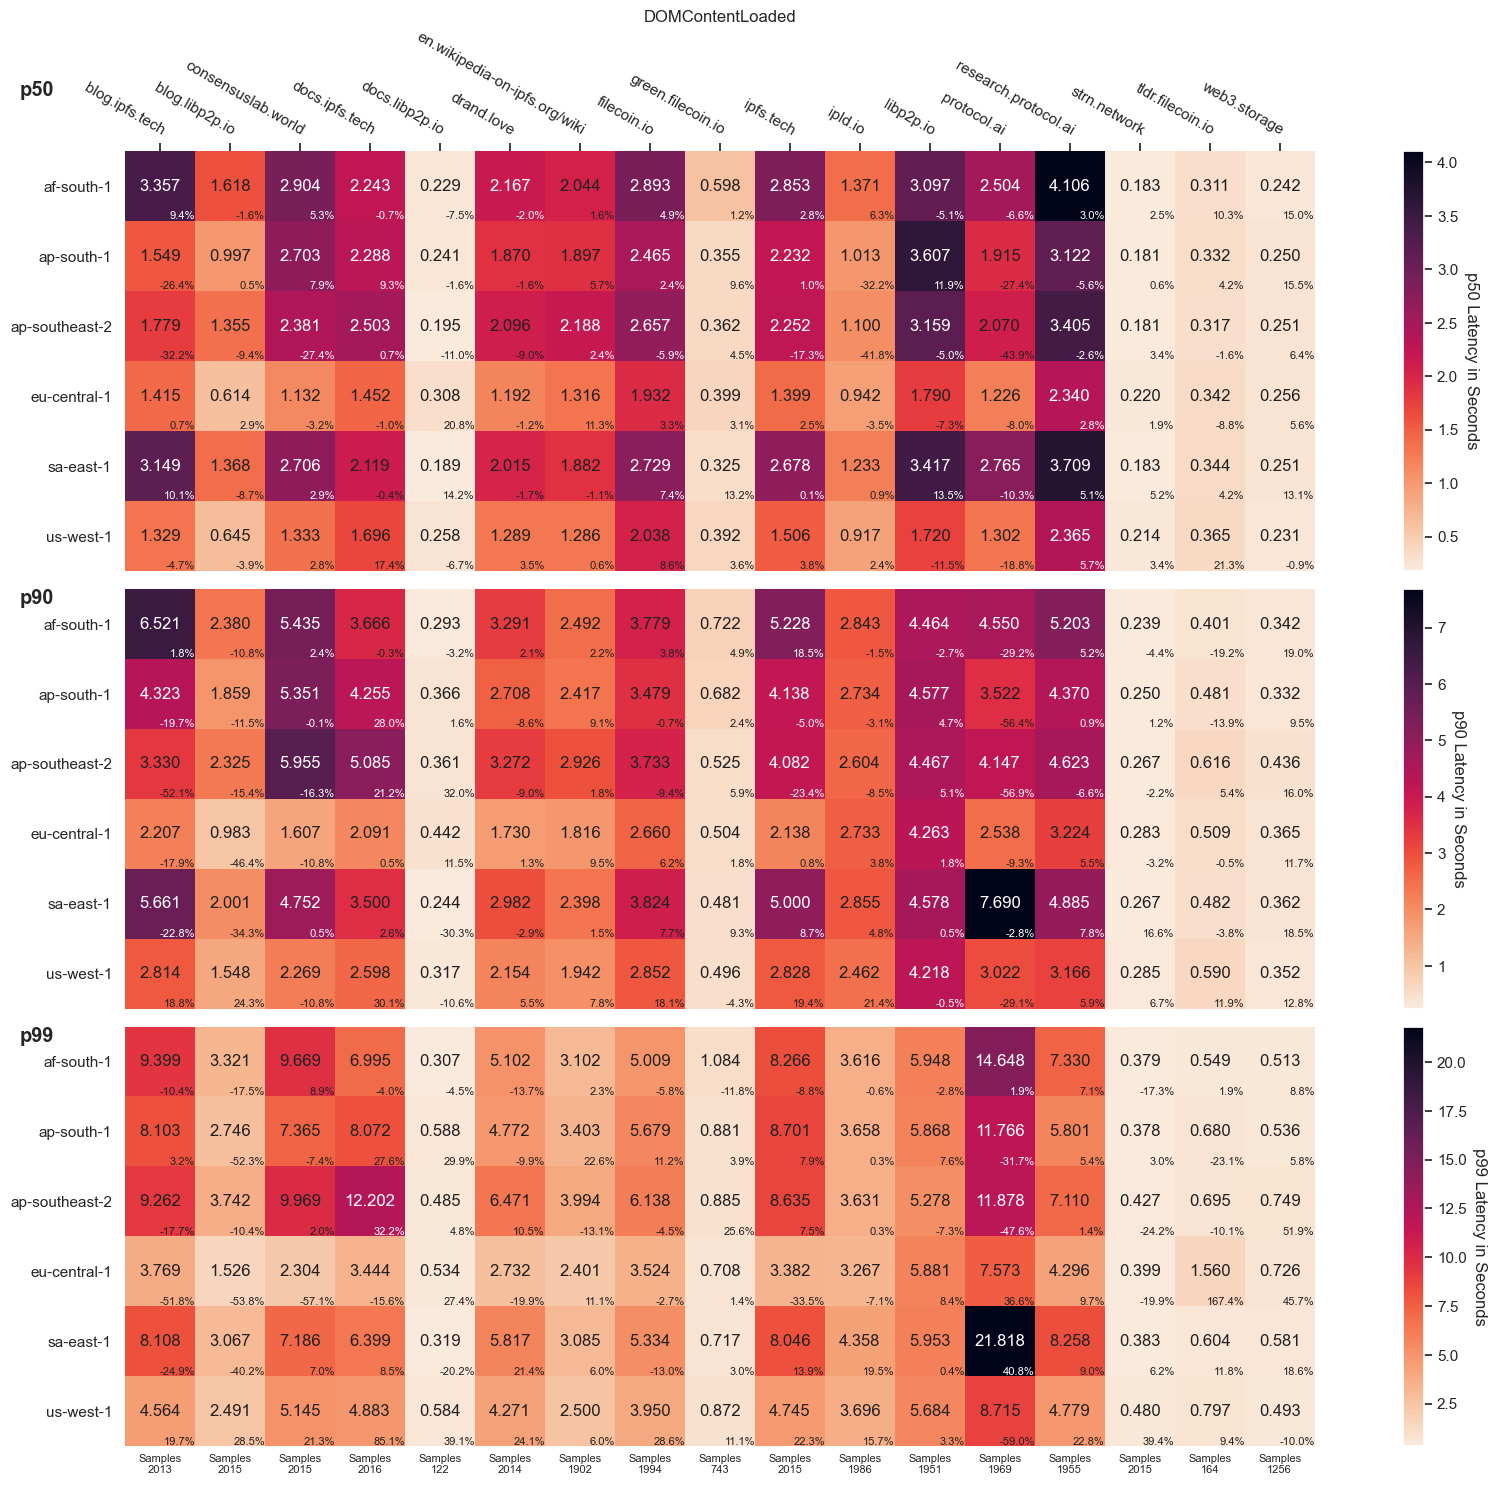

In [94]:
plot_metric("DOMContentLoaded", "domContentLoaded");

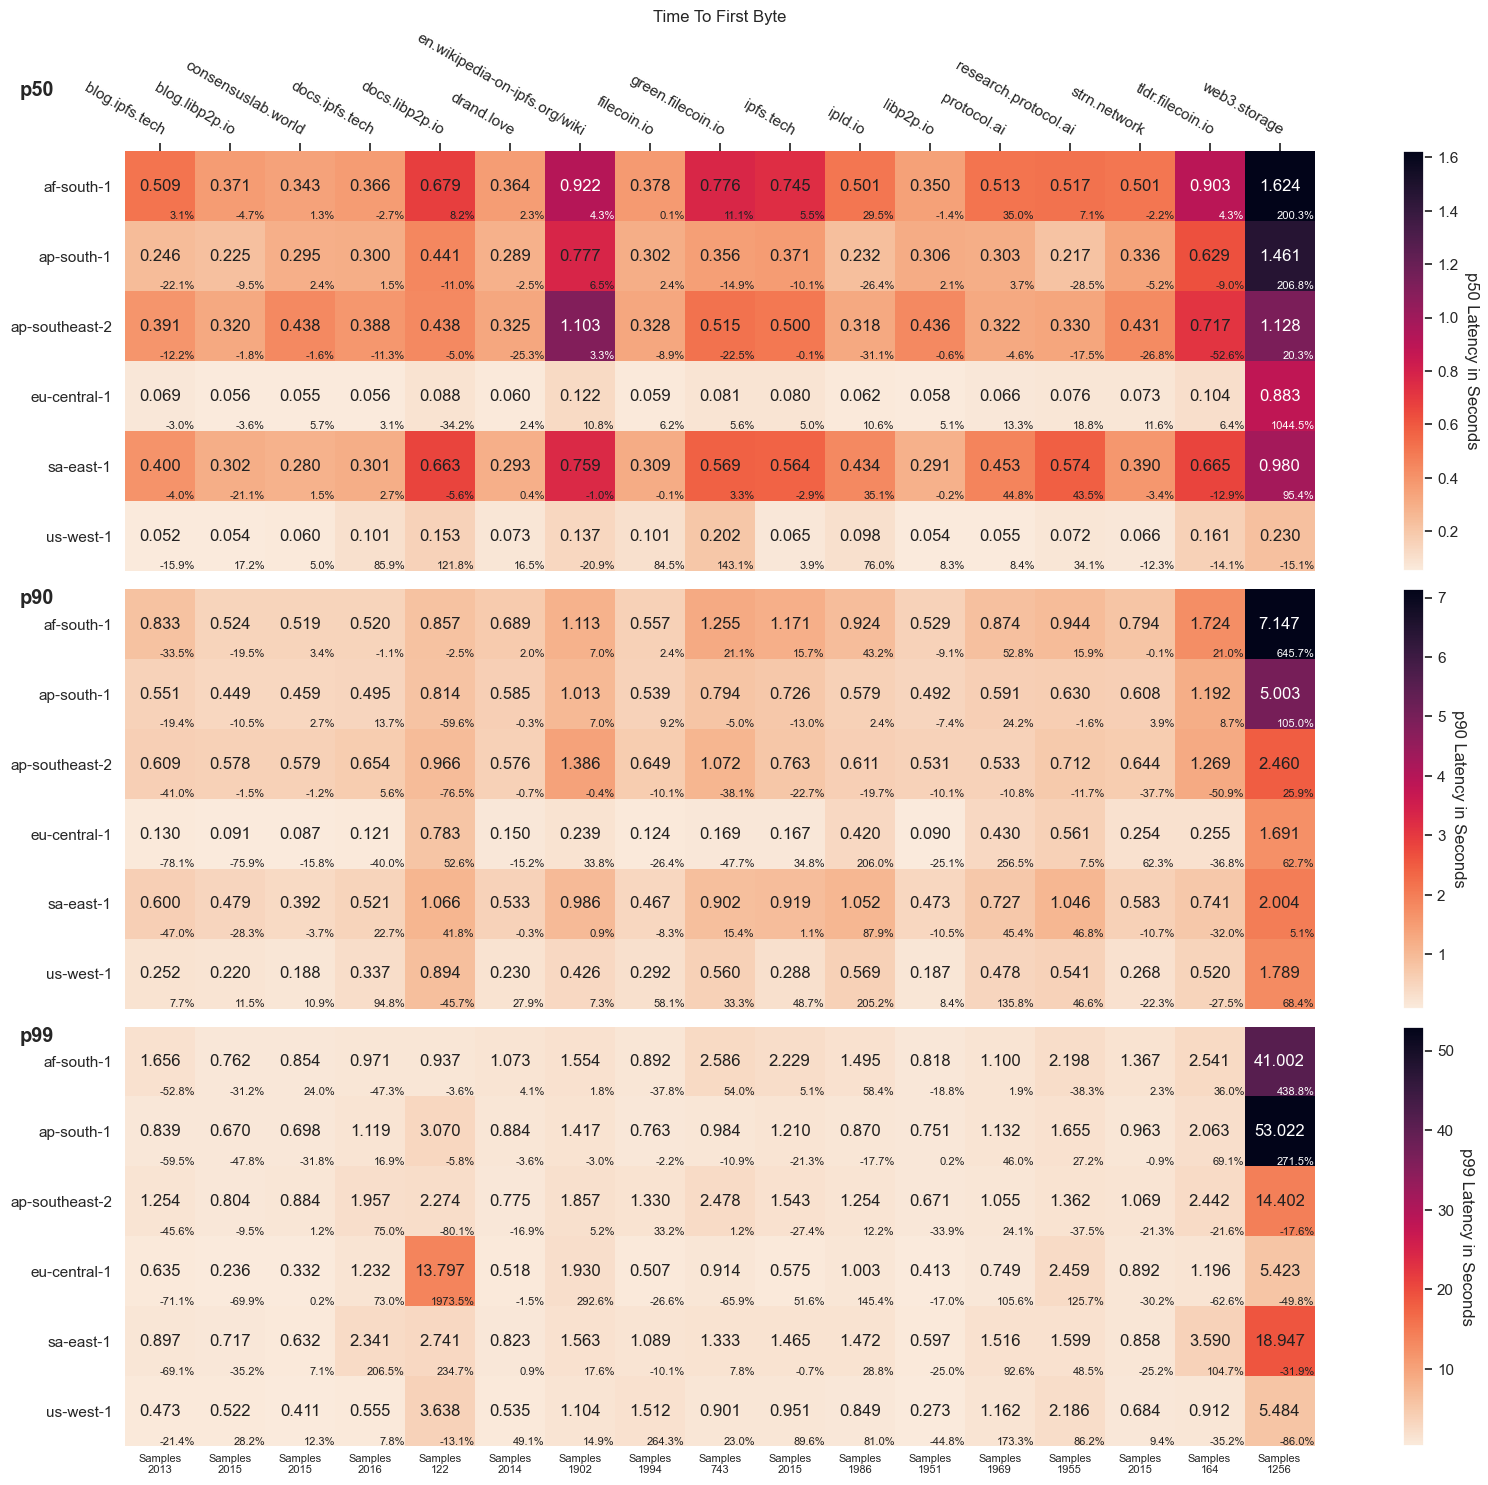

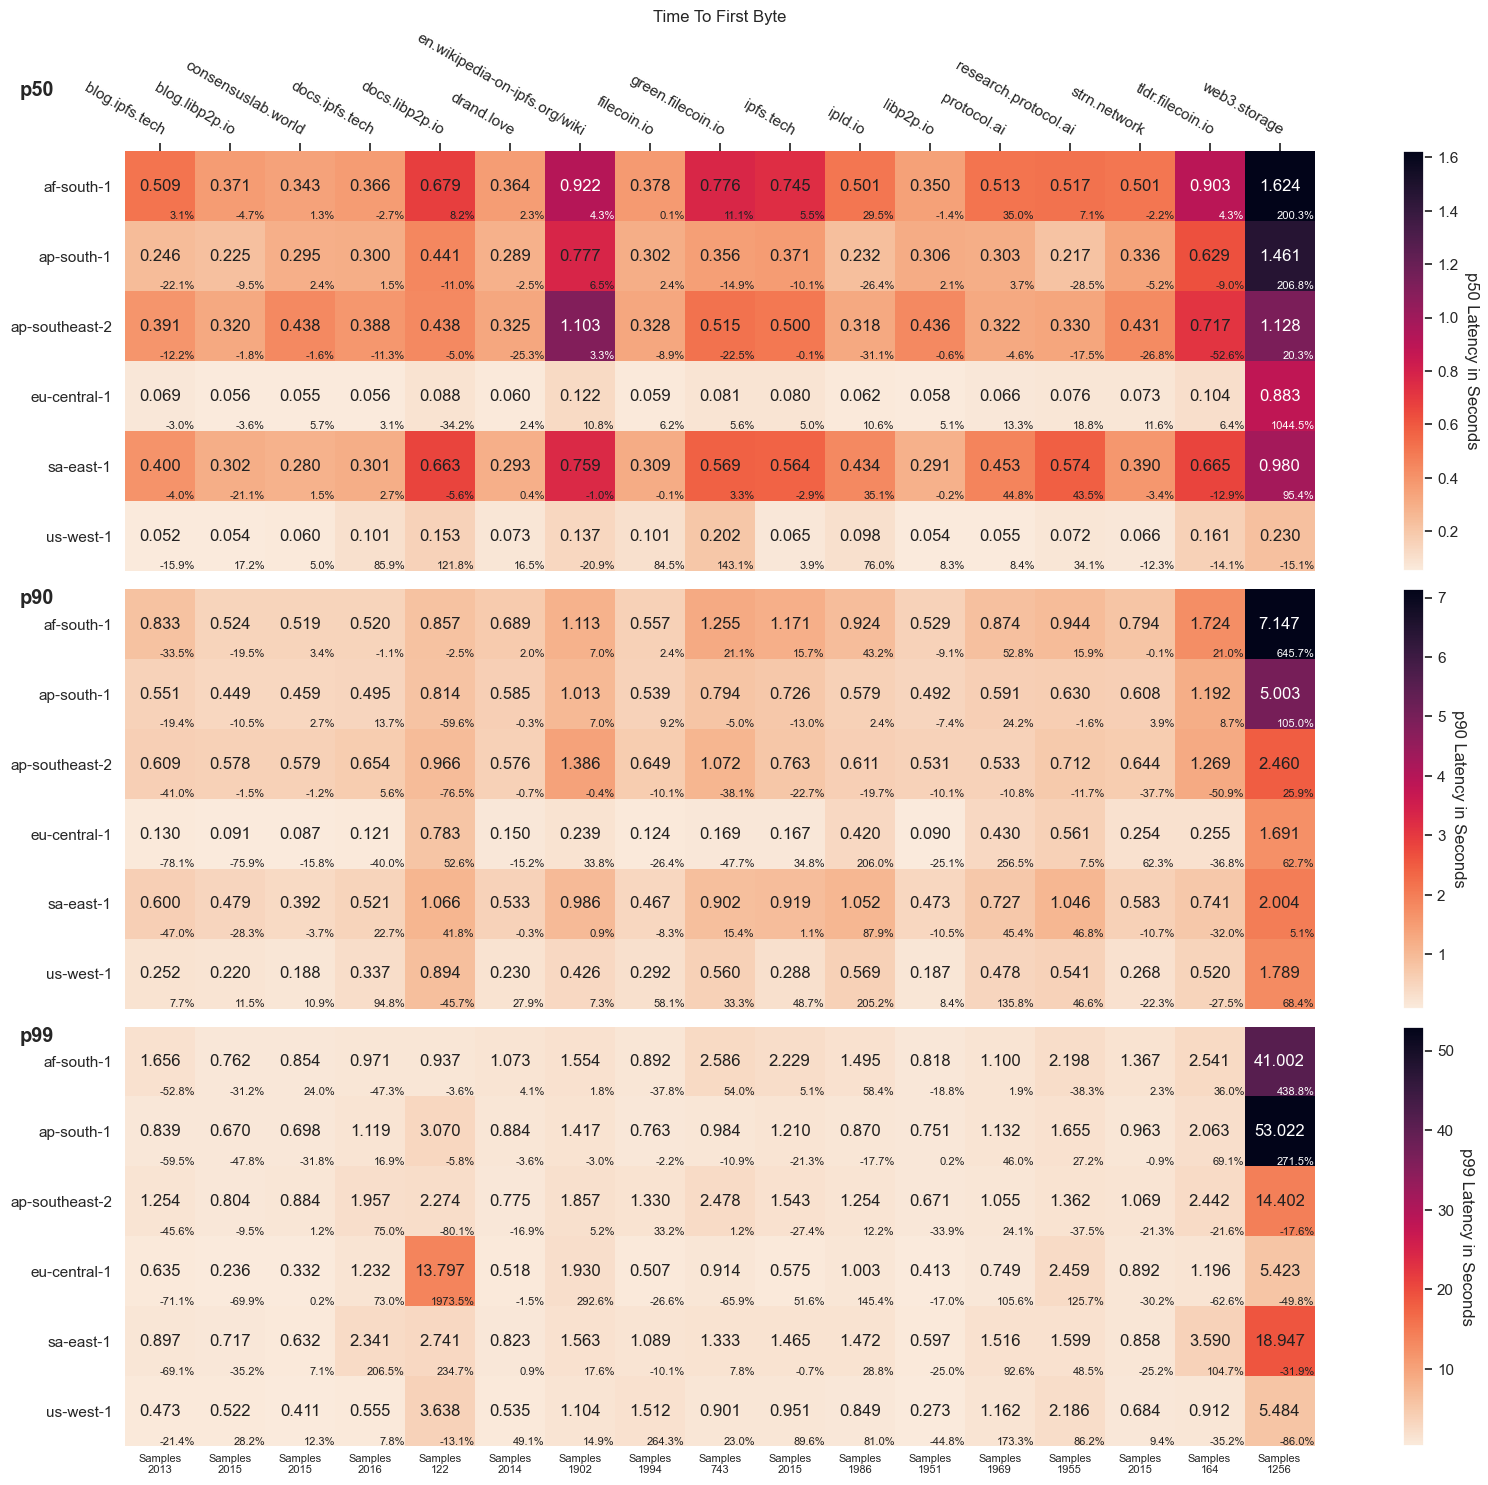

In [95]:
plot_metric("Time To First Byte", "timeToFirstByte")

In [80]:
query = """
SELECT *
FROM measurements
WHERE type = 'KUBO'
  AND created_at >= '2023-02-27 00:00'
  AND created_at < '2023-03-06 00:00'
  AND website != 'ipfs.io'
"""
df_measurements = pd.read_sql_query(query, con=conn)

In [81]:
df_measurements = pd.concat([df_measurements, df_measurements["error"].notnull().rename("has_error")], axis=1)

In [82]:
data = df_measurements.groupby([df_measurements.created_at.dt.floor('d'), "has_error", "website"]).count().drop("created_at", axis=1).reset_index()

In [83]:
dat = data[(data["website"] == "web3.storage")].copy()
dat["%"] = 100*dat["id"] / dat.groupby("created_at")["id"].transform("sum")
dat.groupby("created_at").sum()["id"]

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_67513/3632686596.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dat.groupby("created_at").sum()["id"]


created_at
2023-02-27 00:00:00+00:00    288
2023-02-28 00:00:00+00:00    288
2023-03-01 00:00:00+00:00    288
2023-03-02 00:00:00+00:00    288
2023-03-03 00:00:00+00:00    288
2023-03-04 00:00:00+00:00    288
2023-03-05 00:00:00+00:00    288
Name: id, dtype: int64

Text(0, 0.5, 'Daily Error Rate in % of 288 Website Requests / day')

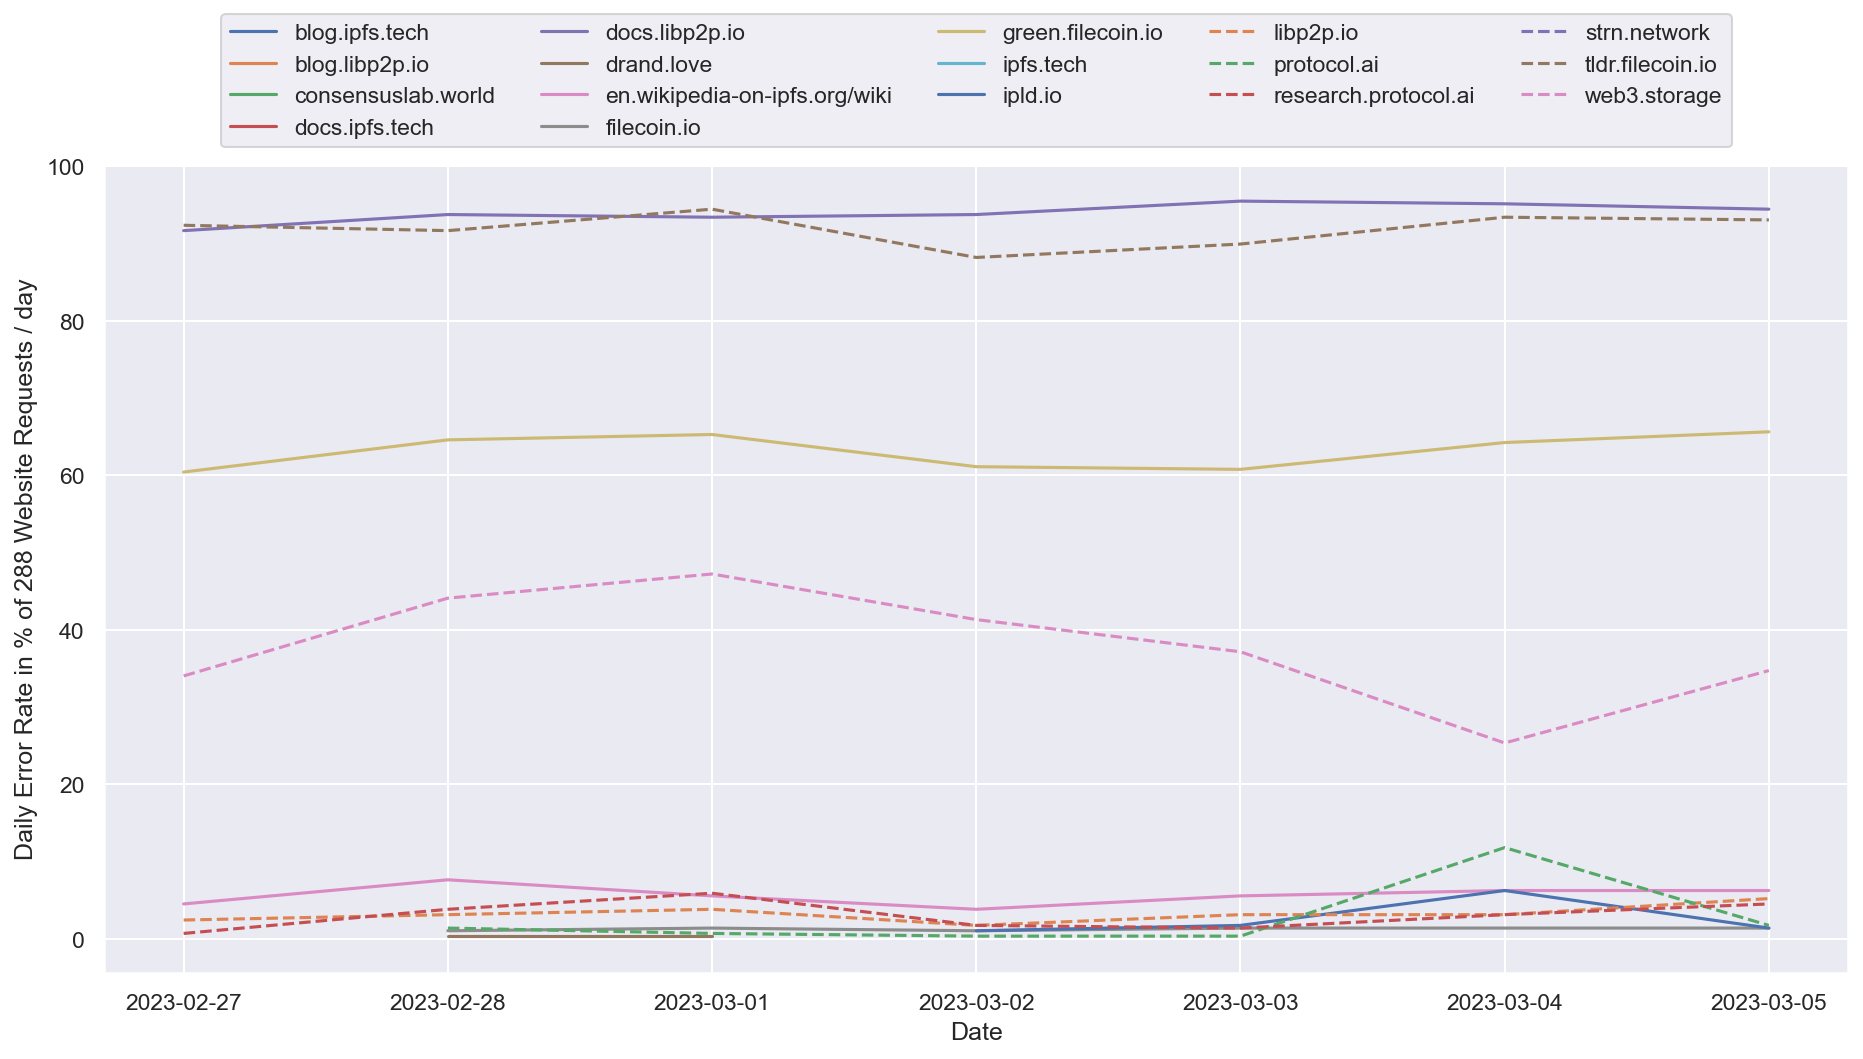

In [85]:
fig, ax = plt.subplots(figsize=[15, 7], dpi=150)

for j, website in enumerate(sorted(data["website"].unique())):
    ls = "solid"
    if j>=10:
        ls ="dashed"
    dat = data[data["website"] == website].copy()
    dat["%"] = 100*dat["id"] / dat.groupby("created_at")["id"].transform("sum")
    dat = dat[dat["has_error"]]

    ax.plot(dat["created_at"], dat["%"], ls=ls, label=website)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=5)
ax.set_xlabel("Date")
ax.set_ylabel("Daily Error Rate in % of 288 Website Requests / day")

In [164]:
query = """
SELECT *
FROM measurements
WHERE error IS NULL
  AND created_at >= '2023-02-27 00:00'
  AND created_at < '2023-03-06 00:00'
  AND website != 'ipfs.io'
"""
df_query = pd.read_sql_query(query, con=conn)

In [165]:
df = pd.concat([df_query, pd.json_normalize(df_query['metrics'])], axis=1)
df = df.groupby([df.created_at.dt.floor('d'), "website", "region", "type"]).median().reset_index()[["created_at", "website", "region", "type", "timeToFirstByte"]]
df

/var/folders/5v/11vhc3kx5yxc2kr1whd5hyxc0000gn/T/ipykernel_67513/980082657.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby([df.created_at.dt.floor('d'), "website", "region", "type"]).median().reset_index()[["created_at", "website", "region", "type", "timeToFirstByte"]]


,created_at,website,region,type,timeToFirstByte
0,2023-02-27 00:00:00+00:00,blog.ipfs.tech,af-south-1,HTTP,2.8500
1,2023-02-27 00:00:00+00:00,blog.ipfs.tech,af-south-1,KUBO,474.0670
2,2023-02-27 00:00:00+00:00,blog.ipfs.tech,ap-south-1,HTTP,4.2325
3,2023-02-27 00:00:00+00:00,blog.ipfs.tech,ap-south-1,KUBO,256.7215
4,2023-02-27 00:00:00+00:00,blog.ipfs.tech,ap-southeast-2,HTTP,2.1425
...,...,...,...,...,...
1418,2023-03-05 00:00:00+00:00,web3.storage,eu-central-1,KUBO,820.5370
1419,2023-03-05 00:00:00+00:00,web3.storage,sa-east-1,HTTP,106.8875
1420,2023-03-05 00:00:00+00:00,web3.storage,sa-east-1,KUBO,876.4565
1421,2023-03-05 00:00:00+00:00,web3.storage,us-west-1,HTTP,125.7100


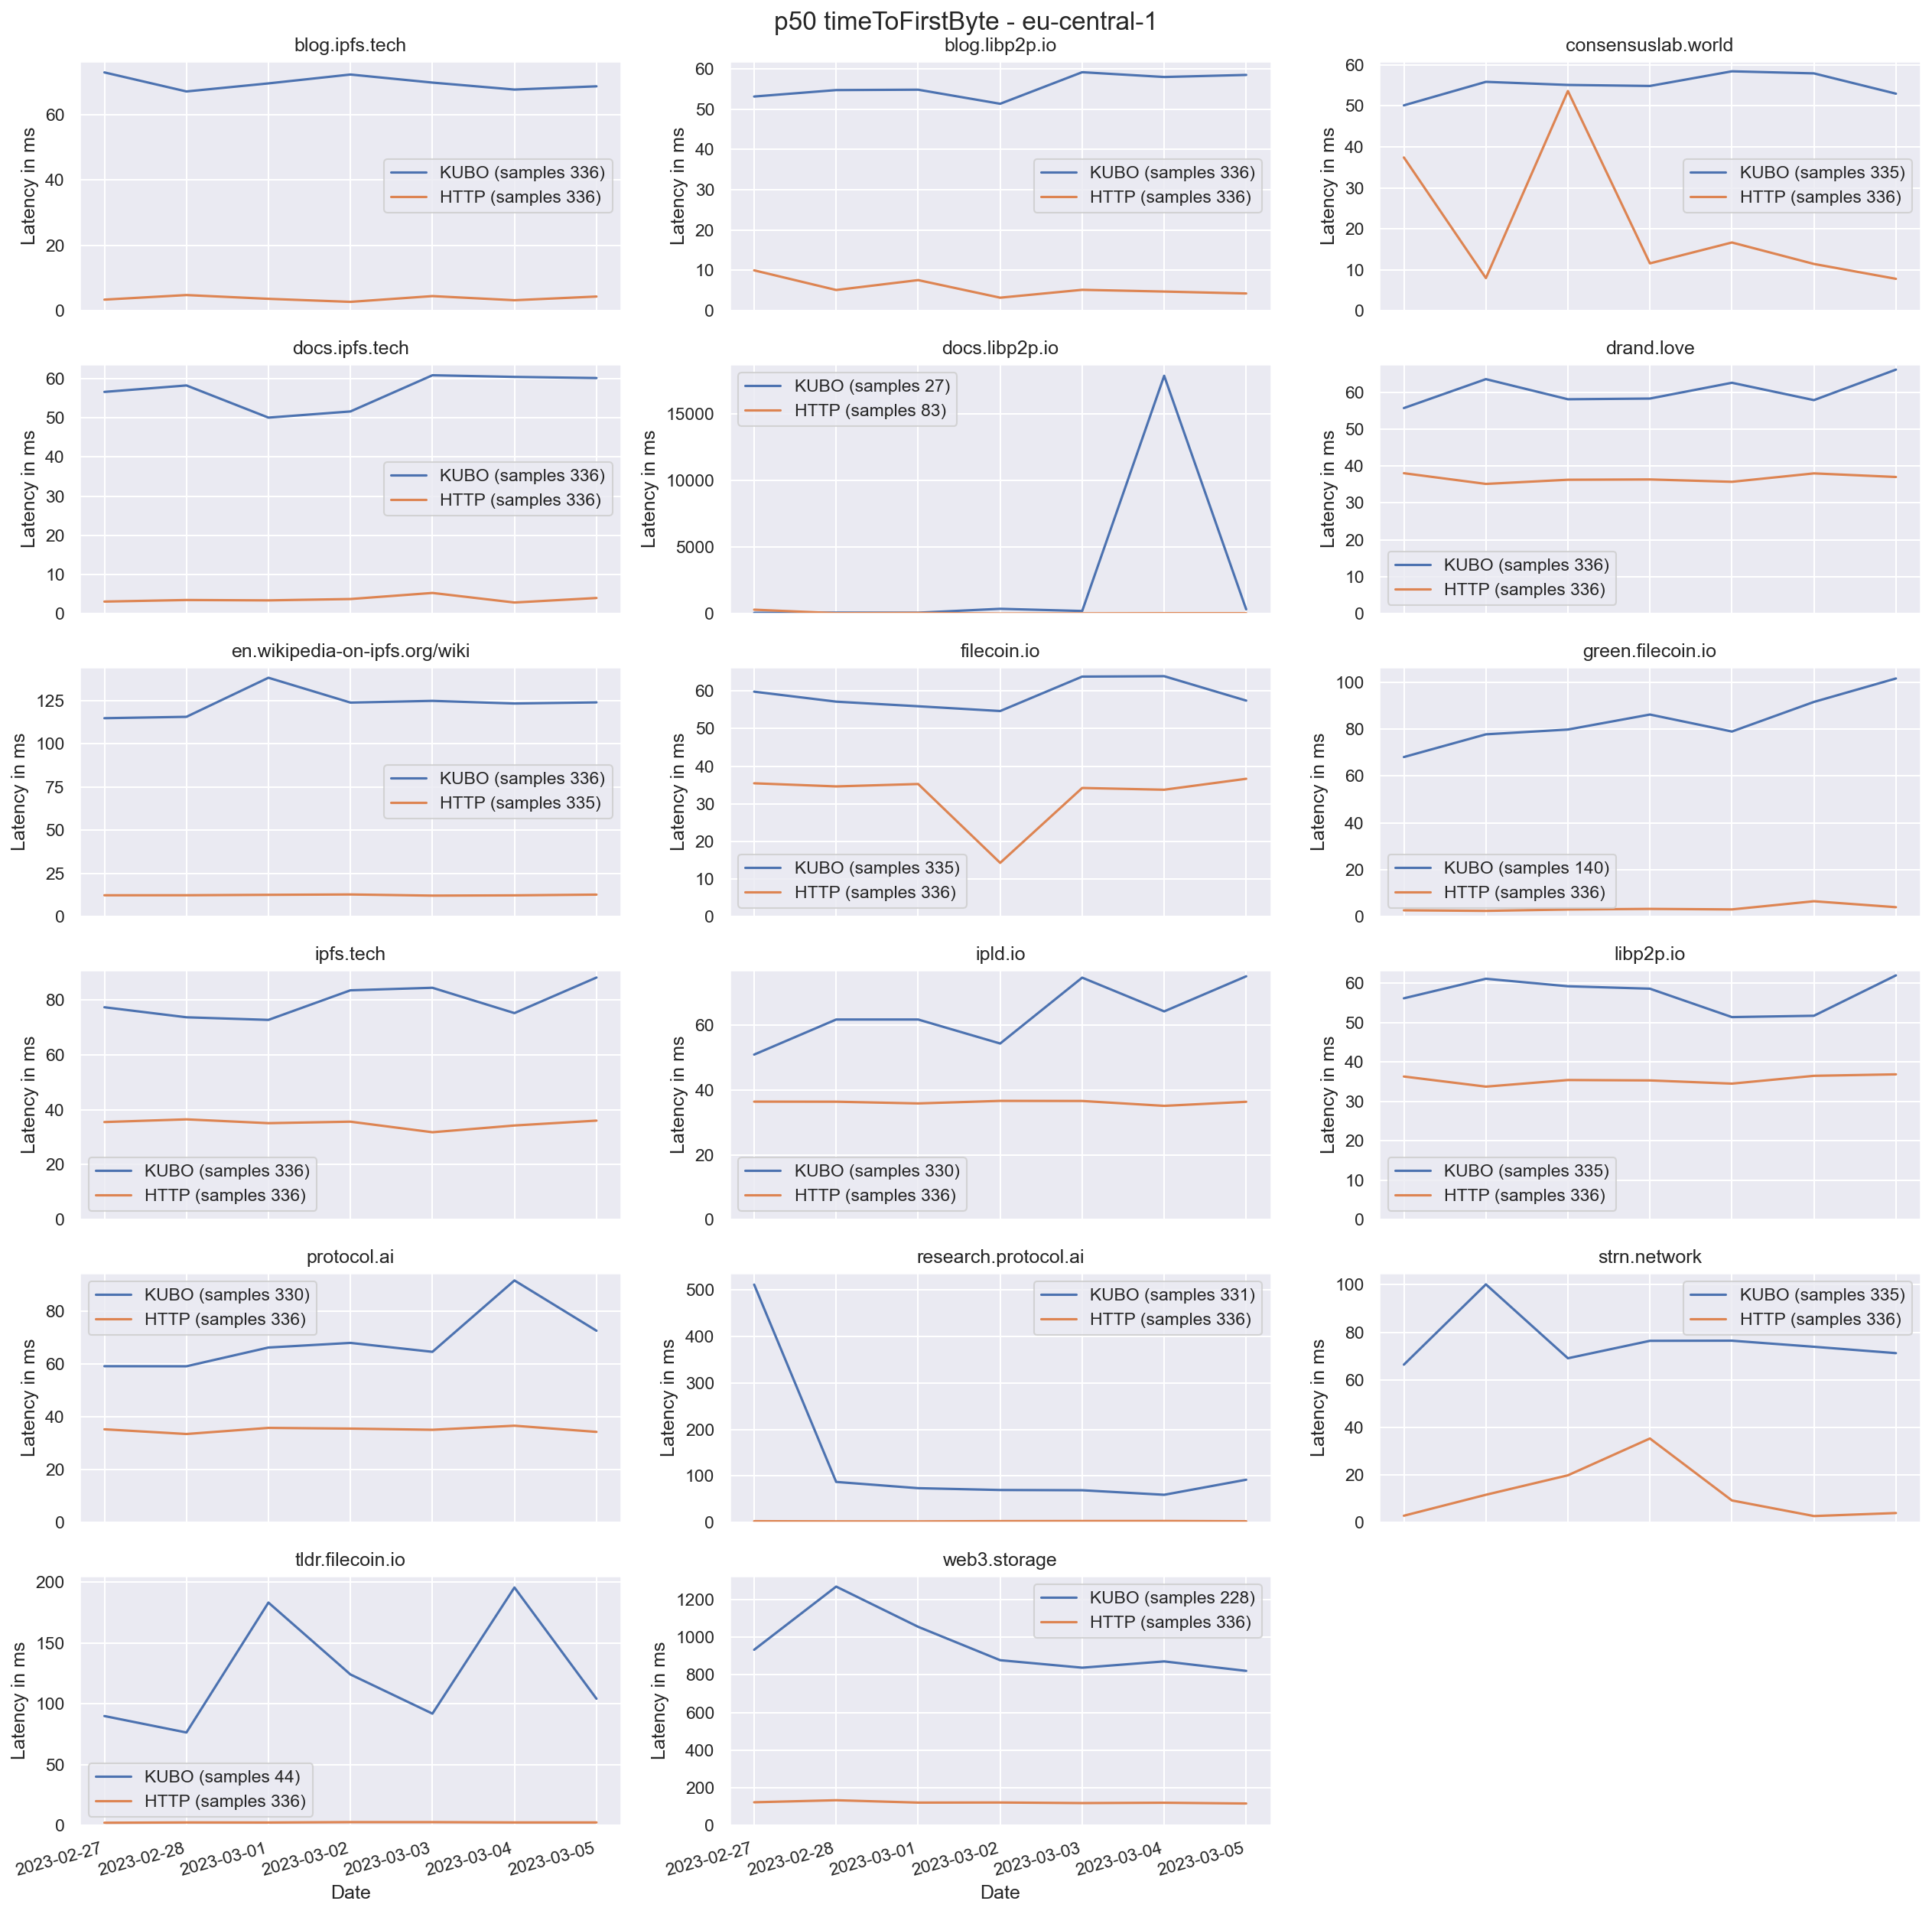

In [169]:
metric = "timeToFirstByte"
region = "eu-central-1"
websites = list(sorted(df["website"].unique()))

fig, axes = plt.subplots(math.ceil(len(websites)/3), 3, figsize=[17, 17], dpi=150, sharex=True)

for j, website in enumerate(websites):
    ax = fig.axes[j]

    dat = df.copy()
    dat = dat[dat["website"] == website]
    dat = dat[dat["region"] == region]
    dat_http = dat[dat["type"] == "HTTP"]
    dat_kubo = dat[dat["type"] == "KUBO"]

    # twin_ax = ax.twinx()
    # twin_ax.plot(dat_http["created_at"], dat_kubo[metric].to_numpy()/dat_http[metric].to_numpy(), label="Ratio", color="gray")
    # twin_ax.set_ylabel("Ratio KUBO/HTTP")
    # twin_ax.set_ylim(0)
    # twin_ax.grid(False)
    # twin_ax.legend(loc="lower right")

    samples_kubo = df_query[(df_query["website"] == website) & (df_query["type"] == "KUBO") & (df_query["region"] == region)].count()["id"]
    samples_http = df_query[(df_query["website"] == website) & (df_query["type"] == "HTTP") & (df_query["region"] == region)].count()["id"]

    ax.plot(dat_kubo["created_at"], dat_kubo["timeToFirstByte"], label=f"KUBO (samples {samples_kubo})")
    ax.plot(dat_http["created_at"], dat_http["timeToFirstByte"], label=f"HTTP (samples {samples_http})")

    ax.set_ylabel("Latency in ms")
    if j+3 >= len(fig.axes):
        ax.set_xlabel("Date")

    ax.set_ylim(0)
    ax.legend()
    ax.set_title(website)

    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
        tick.set_ha("right")

for j in range(len(websites), len(fig.axes)):
    fig.axes[j].remove()

fig.suptitle(f"p50 - {metric} - {region}", fontsize=16)
fig.set_tight_layout(True)

In [239]:
df = pd.concat([df_query, pd.json_normalize(df_query['metrics'])], axis=1)

In [247]:
dat_kubo["timeToFirstByte"].iloc[0]

56.049499999999995

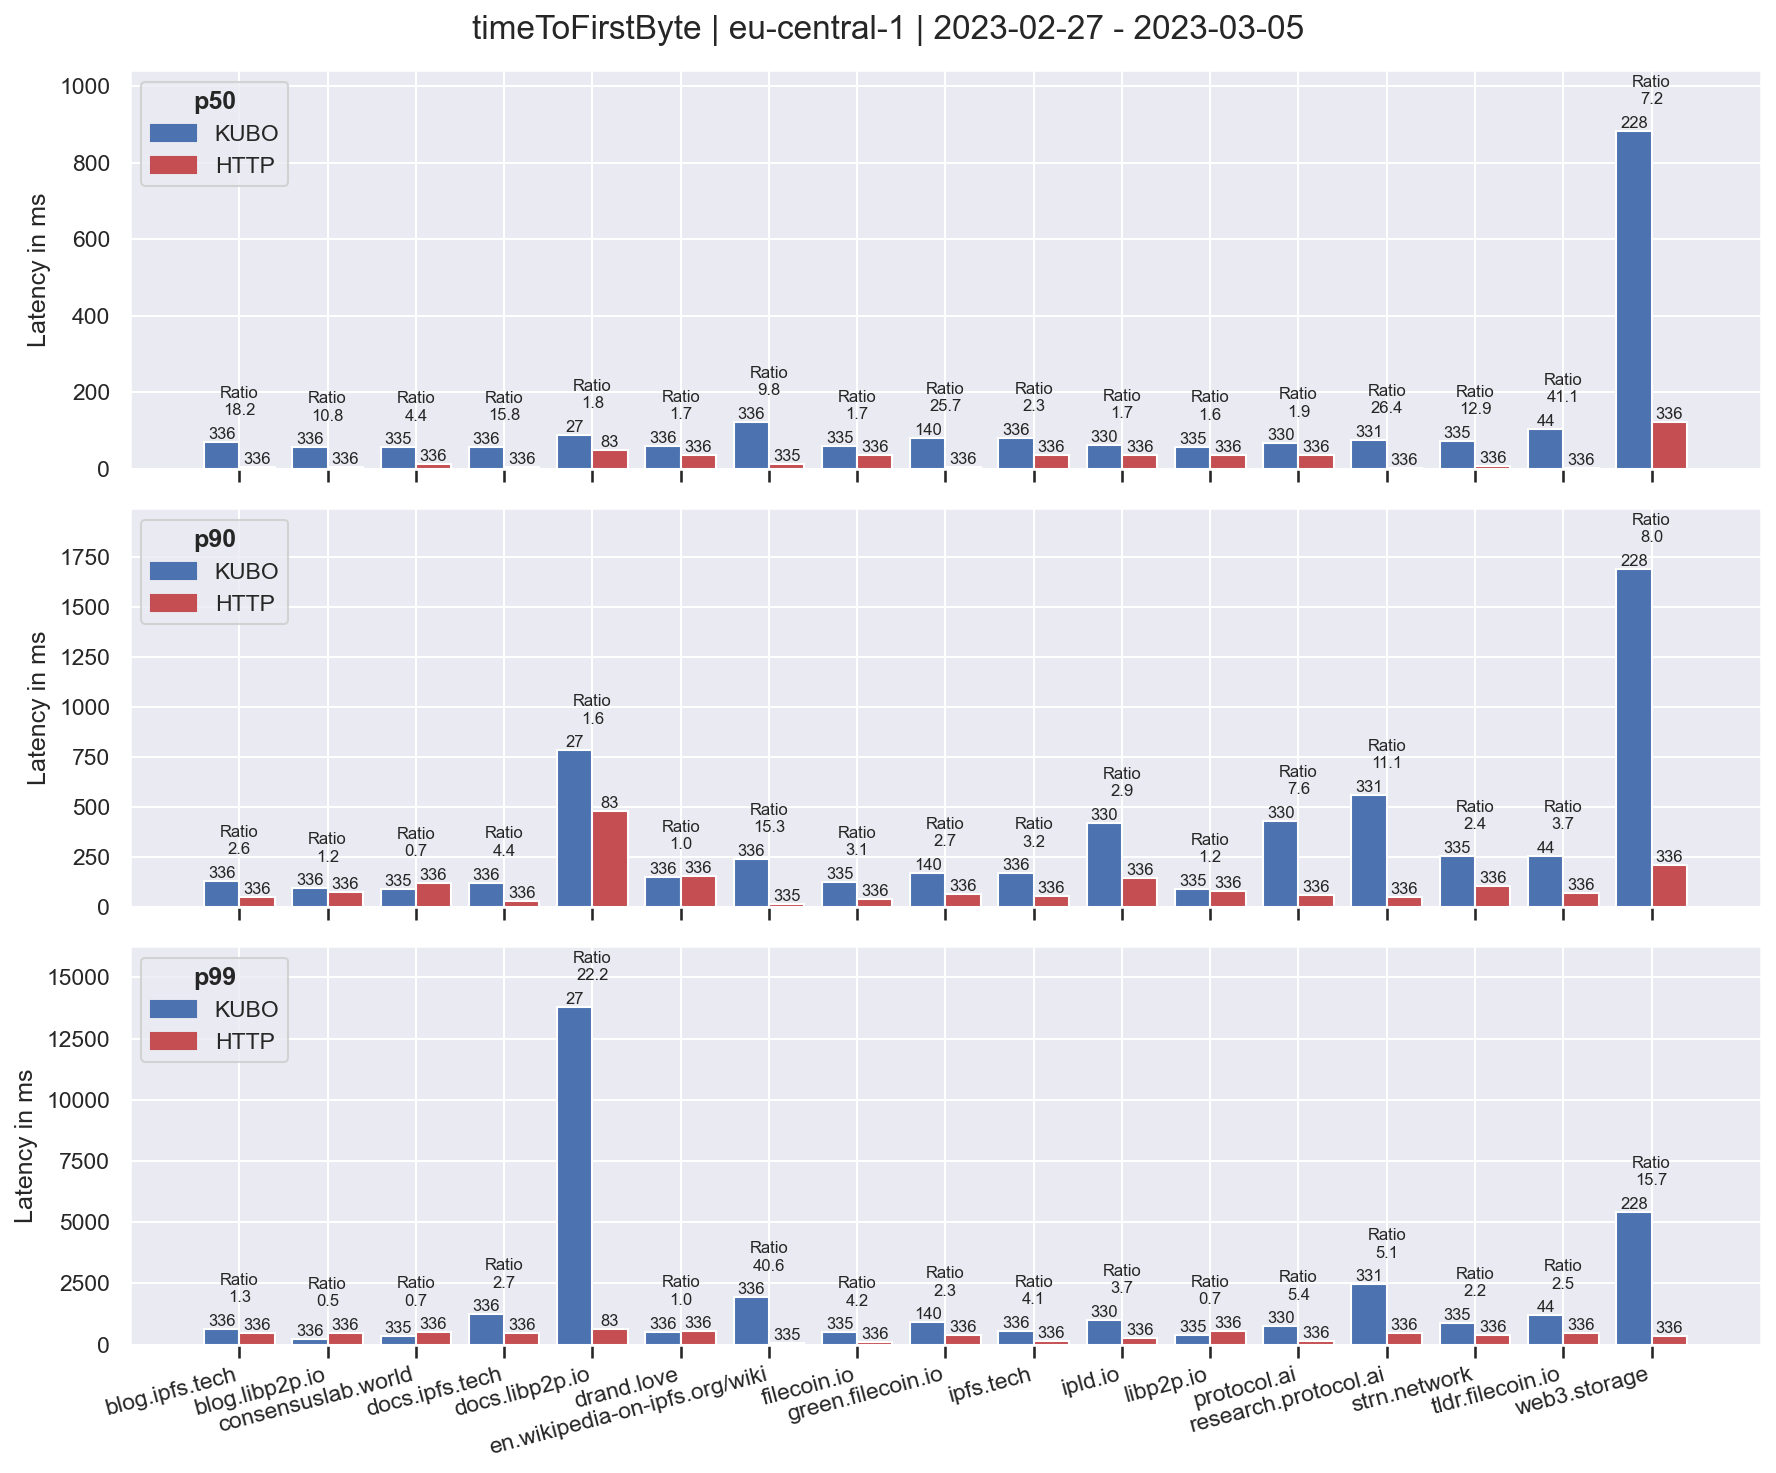

In [262]:
metric = "timeToFirstByte"
region = "eu-central-1"
websites = list(sorted(df["website"].unique()))

fig, ax = plt.subplots(3,1, figsize=[12, 10], dpi=150, sharex=True)

width = 0.4

for i, percentile in enumerate([50, 90, 99]):
    ax = fig.axes[i]

    grouped = df.groupby(["website", "region", "type"]).quantile(percentile/100, numeric_only=True).reset_index()[["website", "region", "type", "timeToFirstByte"]]

    values = []

    xticks = []
    labels = []
    for j, website in enumerate(websites):
        dat = grouped.copy()
        dat = dat[dat["website"] == website]
        dat = dat[dat["region"] == region]
        dat_http = dat[dat["type"] == "HTTP"]
        dat_kubo = dat[dat["type"] == "KUBO"]

        samples_kubo = df_query[(df_query["website"] == website) & (df_query["type"] == "KUBO") & (df_query["region"] == region)].count()["id"]
        kubo_y = dat_kubo["timeToFirstByte"].iloc[0]
        p = ax.bar(j - width, kubo_y, color="b", align="edge", label="KUBO", width=width)
        ax.bar_label(p, labels=[samples_kubo], fontsize=8)

        samples_http = df_query[(df_query["website"] == website) & (df_query["type"] == "HTTP") & (df_query["region"] == region)].count()["id"]
        http_y = dat_http.reset_index()["timeToFirstByte"].iloc[0]
        p = ax.bar(j, http_y, color="r", align="edge", label="HTTP", width=width)
        ax.bar_label(p, labels=[samples_http], fontsize=8)

        values += [kubo_y, http_y]

        xticks += [j]
        labels += [website]

    for j, website in enumerate(websites):
        kubo_y = values[2*j]
        http_y = values[2*j + 1]
        ax.text(j, max(kubo_y, http_y)+0.07*np.max(values), f"Ratio\n{kubo_y/http_y:.1f}", ha="center", va="bottom", fontsize=8)

    ax.tick_params(bottom=True)
    ax.set_xticks(xticks, labels)
    for tick in ax.get_xticklabels():
        tick.set_rotation(15)
        tick.set_ha("right")

    if i+1 == len(websites):
        ax.set_xlabel("Website")

    ax.set_ylabel("Latency in ms")
    ax.set_ylim(0, np.max(values)+0.18*np.max(values) )

    legend_elements = [
        Patch(facecolor='b', edgecolor='b', label='KUBO'),
        Patch(facecolor='r', edgecolor='r', label='HTTP')
    ]

    ax.legend(title=f"p{percentile}", handles=legend_elements, loc='upper left', title_fontproperties={"weight": "bold"})

fig.suptitle(f"{metric} | {region} | {df_query['created_at'].min().strftime('%Y-%m-%d')} - {df_query['created_at'].max().strftime('%Y-%m-%d')}", fontsize=16)
fig.set_tight_layout(True)